In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd

In [4]:
img1 = cv2.imread('./field1.png', cv2.IMREAD_UNCHANGED)
#img = cv2.GaussianBlur(img,(3,3),1)
img2 = cv2.imread('./field2.png', cv2.IMREAD_UNCHANGED)
#img2 = cv2.GaussianBlur(img2,(3,3),1)
sw_lat = 39.29659584795485
sw_lng = -91.55355996810053
ne_lat = 39.300794835699975
ne_lng = -91.53768871961418
field_lat = 39.298716368246005
field_lng = -91.54533269271144

field_x = abs((field_lng-ne_lng)*(img2.shape[1]/(ne_lng-sw_lng)))
field_x = int(round(field_x))
field_y = abs((field_lat-ne_lat)*(img2.shape[0]/(ne_lat-sw_lat)))
field_y = int(round(field_y))

In [5]:
def invert_pixels(self):
    img = cv2.bitwise_not(self)
    return img

def get_circle_mask(center, radius, img):
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.circle(mask, (center[0],center[1]), radius, (255,255,255), -1)
    return mask

def get_circle(center, radius, img):
    mask = get_circle_mask(center, radius, img)
    result = img & mask
    
    mask_sum = np.sum(mask)
    result_sum = np.sum(result)
    coverage = (result_sum-mask_sum)/mask_sum
    return [result,coverage]

def get_ring(center,radius, img, indx):
    mask = np.zeros(img.shape, dtype=np.uint8)
    cv2.circle(mask, (center[0],center[1]), radius, (255,255,255), 1)
    
    img_ring = ((mask)&(invert_pixels(img))).nonzero()
    img_ring = np.array(img_ring)
    
    if img_ring.size != 0:
        img_ring = np.array([img_ring[1],img_ring[0]])
        angles = np.arctan2(img_ring[1] - center[1], img_ring[0] - center[0])
        #print(angles)
        angles = np.where(angles >= 0, angles, angles + 2*math.pi)
        #print(angles)
        #print(np.rad2deg(angles))
        #print('')
        distances = np.sqrt((img_ring[0] - center[0])**2 + (img_ring[1] - center[1])**2)
        angle1 = np.arctan2(img_ring[1] - center[1] + 2, img_ring[0] - center[0] - 2)
        angle2 = np.arctan2(img_ring[1] - center[1] - 2, img_ring[0] - center[0] + 2)
        angle3 = np.arctan2(img_ring[1] - center[1] + 2, img_ring[0] - center[0] + 2)
        angle4 = np.arctan2(img_ring[1] - center[1] - 2, img_ring[0] - center[0] - 2)
        angle1 = np.where(angle1 >= 0, angle1, angle1 + 2*math.pi)
        angle2 = np.where(angle2 >= 0, angle2, angle2 + 2*math.pi)
        angle3 = np.where(angle3 >= 0, angle3, angle3 + 2*math.pi)
        angle4 = np.where(angle4 >= 0, angle4, angle4 + 2*math.pi)
        img_ring = np.vstack((img_ring, angles, distances))
        for i in range(len(img_ring[0])):
            a1 = 0.0
            a2 = 0.0
            if angles[i] < math.pi/2 or ((angles[i] < 3*math.pi/2) and (angles[i] >= math.pi)):
                #a1 = angles[i] + (angle1[i]-angles[i])/2
                #a2 = angles[i] + (angle2[i]-angles[i])/2
                a1 = angle1[i]
                a2 = angle2[i]
            else:
                #a1 = angles[i] + (angle3[i]-angles[i])/2
                #a2 = angles[i] + (angle4[i]-angles[i])/2
                a1 = angle3[i]
                a2 = angle4[i]
            a_min = min(a1,a2)
            a_max = max(a1,a2)
            if a_min < 0.75 and a_max > 5.5:
                a_min = a_min + 2*math.pi
            r = int(img.shape[1])            
            cv2.ellipse(img, (center[0],center[1]), (r,r), 0,
                        np.rad2deg(a_min), np.rad2deg(a_max), 255, -1)
        #print_img_points(img, img_ring.T, indx)
            #print(a_min,',', a_max)
            #print(np.rad2deg(a_min),np.rad2deg(a_max))
        return [img_ring, img]
    img_ring = np.array([[],[],[],[]])
    return [img_ring, img]

def get_imgs(img):    
    cA = []
    eA = []
    hcorner_centroids = []
    imgs = []
    print(img.shape)
    for i in range(4):
        # get harris corner image
        cImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        cImg = np.float32(cImg)
        dst = cv2.cornerHarris(cImg,2,1,0.04)
        dst = cv2.dilate(dst,None)
        cImg[dst>0.01*dst.max()]=[0]
        ret, cImg = cv2.threshold(cImg, 90, 255, cv2.THRESH_BINARY)
        cImg = np.uint8(cImg)
        cA.append(cImg)
        
        # find centroids of harris corner
        ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
        dst = cv2.dilate(dst, None, iterations=1)
        dst = np.uint8(dst)
        ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
        hcorner_centroids.append(centroids)
        
        eImg = cv2.Canny(img,50,150)
        eImg = invert_pixels(eImg)
        ret, eImg = cv2.threshold(eImg, 90, 255, cv2.THRESH_BINARY)
        eA.append(eImg)
        
        imgs.append(img)
        img = cv2.pyrDown(img)
        
    return [cA, hcorner_centroids, eA, imgs]

def print_imgs(imgs):
    imgs = imgs[3] + imgs[2] + imgs[0]
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

    for i in range(len(imgs)):
        plt.subplot(math.ceil(len(imgs)/2),2,i+1)
        plt.imshow(imgs[i],'gray')
        plt.xticks([]),plt.yticks([])
        
    plt.show()
    #plt.savefig("./test_img2_pyramid")
    
def print_polygon(img, pts, center):
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img,[pts],True,(150,150,150))
    cv2.circle(img, (center[0],center[1]), 2, (150,0,0), -1)
    
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(img,'gray')
    plt.xticks([]),plt.yticks([])
    #plt.show()
    plt.savefig("./test_img1_field")
    
def print_img(img, point):
    cv2.circle(img, point, 1, (150,0,0), -1)
    
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(img,'gray')
    plt.xticks([]),plt.yticks([])
    plt.show()
    #plt.savefig("./test_img1_Harrisc_corners")
    
def print_img_points(image, points, i):
    for point in points:
        point = (int(point[0]), int(point[1]))
        cv2.circle(image, point, 1, (150,0,0), -1)
    
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.imshow(image,'gray')
    plt.xticks([]),plt.yticks([])
    plt.show()
    #plt.savefig("./Lidar/%d"%i, transparent=True)
    
def get_start_img(imgs):
    imgA = []
    for i in range(len(imgs[2])):
        img = imgs[2][i]
        center = [int(round(field_x/(2**i))),int(round(field_y/(2**i)))]
        radius = int(round(img.shape[0]/8))
        img, coverage = get_circle(center, radius, img)
        if coverage < 0.01:
            return [i, center, radius]
    return  [len(imgs[2])-1, center, radius]

def closest_point(pt, pts):
    dist = np.sqrt(np.sum((pts - pt)**2, axis=1))
    return [np.amin(dist),np.argmin(dist)]

def remove_small_angles(p_df, img):
    #print('1', p_df, sep='\n')
    p_df = p_df.copy()
    
    p0 = cv2.approxPolyDP(p_df.values, int(round(img.shape[1]*.01)), True).reshape((-1,2))
    #print(p0)
    p1 = np.roll(p0, 2)
    #print(p1)
    p2 = np.roll(p0, -2)
    
    v1 = p1 - p0
    v2 = p2 - p0

    v1_u = v1 / np.array([np.linalg.norm(v) for v in v1])[:, np.newaxis]
    v2_u = v2 / np.array([np.linalg.norm(v) for v in v2])[:, np.newaxis]
    #print('v1_u:', v1_u, 'v2_u:', v2_u, sep='\n')

    #v1_v2_dot = np.einsum('ij,ij->i',v1_u,v2_u)

    angle = np.arccos(np.clip(np.einsum('ij,ij->i',v1_u,v2_u), -1.0, 1.0))
    zeros = np.zeros(p0.shape, dtype=np.uint8)
    #print(p0)
    p0 = np.where(angle[:, None] < 1.2, p0, zeros)
    p0 = p0[np.nonzero(p0)].reshape((-1,2))
    #print(p0)
    p0 = p0.T
    #print(p_df['angle'])
    row_count = p_df.shape[0]
    #print('2', p_df, sep='\n')
    mask_x = np.logical_not(p_df['x'].isin(p0[0]))
    mask_y = np.logical_not(p_df['y'].isin(p0[1]))
    p_df = p_df.loc[mask_x | mask_y]
    new_row_count = p_df.shape[0]
    #print('3', p_df, sep='\n')
    #print_polygon(img,p_df.values,(600, 180))
    if row_count != new_row_count:
        return remove_small_angles(p_df, img)
    
    return p_df

def clean_polygon(p_df, corners, img):
    p_df = p_df.copy()
    p_df.columns = ['x','y','angle_origin','distance_origin']
    
    # Code for using harris corner image instead of centroids
    corners = invert_pixels(corners).nonzero()
    corners = np.dstack((corners[1], corners[0]))[0]
    
    # Get set of corners
    #print('corners:', corners, sep='\n')
    #print(np.array(corners))
    #corners = np.array(corners.T)
    #print(corners)
    corners = corners[1:]
    #corners = np.array([corners[1],corners[0]])
    corners = np.round(corners/2).astype(int)
    #print(corners)
    #print_polygon(img, corners, (center[0], center[1]))
    vertices = p_df[['x','y']].values
    print_polygon(img, vertices.astype(int), (center[0],center[1]))
    closest_index = np.array([closest_point(pt,corners) for pt in vertices])
    #print('closest_index:', closest_index, sep='\n')
    corner_dist = closest_index.T[0]
    closest_index = closest_index.T[1].astype(int)
    p_df['closest_corner_x'] = np.array([corners[x][0] for x in closest_index])
    p_df['closest_corner_y'] = np.array([corners[x][1] for x in closest_index])
    p_df['corner_dist'] = corner_dist
    #length_std = np.std(p_df['length1'].values)
    p_df = p_df.sort_values('corner_dist')
    p_df.reset_index(drop=True, inplace=True)
    #print(p_df)
    p_df = p_df.loc[p_df['corner_dist'] <= p_df['corner_dist'][int(p_df.shape[0]*0.75)]]
    #print(p_df)
    #print(int(p_df.shape[0]*0.1), int(p_df.shape[0]*0.25), int(p_df.shape[0]*0.9), sep='\n')
    p_df = p_df.sort_values('angle_origin')
    p_df = p_df[['closest_corner_x', 'closest_corner_y']].drop_duplicates()
    #print(p_df)
    
    p_df.columns = ['x', 'y']
    p_df = remove_small_angles(p_df, img)
    
    p_df_a = cv2.approxPolyDP(p_df.values, int(round(img.shape[1]*.01)), True)
    #print(p_df_a)
    p_df = pd.DataFrame(p_df_a.reshape((-1,2))) 
    p_df.columns = ['x', 'y']
    
    p0 = p_df[['x','y']].values
    p1 = np.roll(p0, 2)
    p2 = np.roll(p0, -2)
    
    length1 = np.sqrt((p1.T[0] - p0.T[0])**2 + (p1.T[1] - p0.T[1])**2)
    length2 = np.roll(length1, -1)
    p_df['length1'] = length1
    p_df['length2'] = length2
    #print(p0,p1,p2,v1,v2)
    #print(p_df['length1'].hist(bins=100))
    
#     print(p_df.loc[(p_df['length1'] > length_std*2) | (p_df['length2'] > length_std*2)])
    #print(p_df)
#     print(img.shape)
    return p_df

    
def get_lidar_polygon(center, radius, img, img_corners):
    image = img.copy()
    radius = int(radius/2)
    length = int(image.shape[1]/2) - radius
    pixels = []
    #print(img.shape)
    
    for i in range(length):
        #if i % 2 ==1:
        ring, image = get_ring(center, radius+i+1, image, i)
        pixels.append(ring)
        #vertices = np.concatenate(pixels,axis=1)
        #print_img_points(image, vertices.T)
    
    vertices = np.concatenate(pixels,axis=1)
    vertices_df = pd.DataFrame(vertices.T, columns=['x','y','angle_origin','distance_origin'])
    vertices_df = vertices_df.sort_values('angle_origin')
    #print(print_polygon(img, vertices_df[['x','y']].values, center))
    #print(vertices_df[['x','y']].values)
    vertices_df = clean_polygon(vertices_df, img_corners, img)
    vertices = vertices_df[['x','y']].values
    print(vertices)
    return vertices.astype(int)   

(400, 1170, 4)


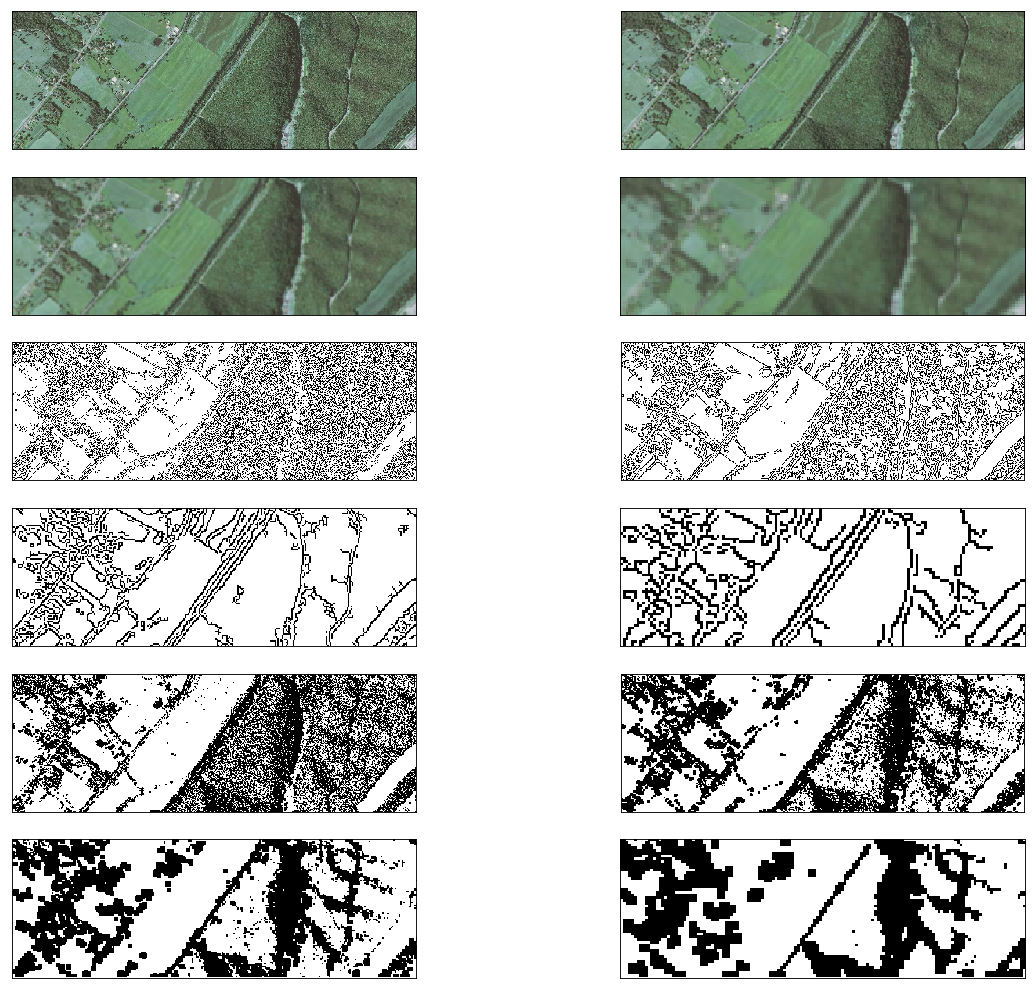

/home/nathanael/.local/share/virtualenvs/agfield-0W6eAqo7/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in ulong_scalars
  app.launch_new_instance()


[[153  38]
 [118  88]
 [112  80]
 [ 94  82]
 [ 84  70]
 [ 95  47]
 [104  38]
 [112  38]
 [124  19]]


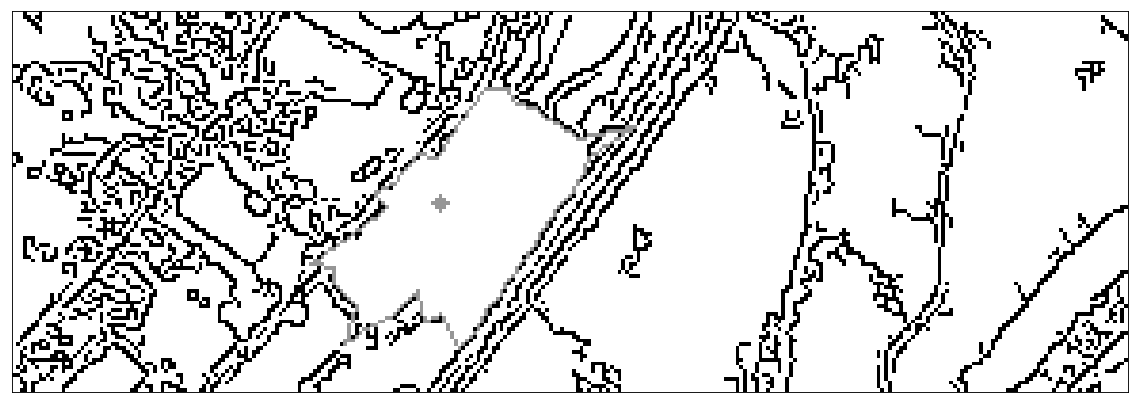

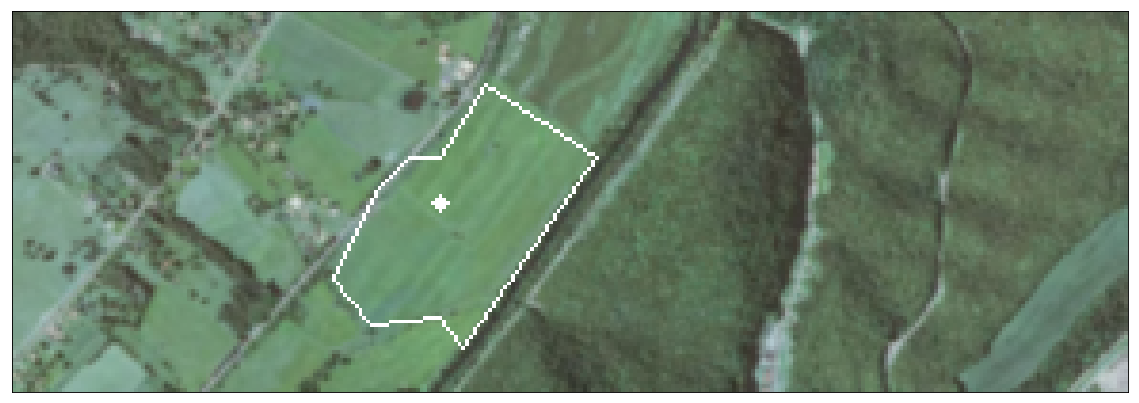

In [6]:
#field_x, field_y = 300, 180
#field_x, field_y = 600, 180
#field_x, field_y = 1000, 200
field_x, field_y = 450, 200

imgs = get_imgs(img1)
print_imgs(imgs)
index, center, radius = get_start_img(imgs)
index2 = index
if index > 0:
    index2 = index - 1
#print(index, index2)
pic = imgs[3][index].copy()
#print_img(img2,(center[0],center[1]))
#print_img(imgs[2][index],(center[0],center[1]))
#print_img(imgs[0][index2],(center[0]*2,center[1]*2))
#print('img:', imgs[0][index2],'corners:', imgs[1][index2], sep='\n')
polygon = get_lidar_polygon(center, radius, imgs[2][index], imgs[0][index2])
print_polygon(pic,polygon,center)


#print_imgs(imgs)
#print(polygon)
#print_imgs(get_start_img(imgs))

In [152]:
a = np.arange(-10, 10).reshape((10,2))
b = np.arange(0,10)
#np.where(a > 0, a, a +20)
print(a)

#a / b[:, np.newaxis]
print(closest_point([0,1], a))
print(a[5][1])

[[-10  -9]
 [ -8  -7]
 [ -6  -5]
 [ -4  -3]
 [ -2  -1]
 [  0   1]
 [  2   3]
 [  4   5]
 [  6   7]
 [  8   9]]
[0.0, 5]
1


In [24]:
df = pd.DataFrame(np.random.randint(0,10,size=(10, 4)), columns=list('ABCD'))
df["E"]=df["D"].shift()
df["E"][:1]=df["D"].iloc[-1:]
df['E'] = df['E'].astype(int)
df["F"]=df["D"].shift(-1)
df["F"][-1:]=df["D"].iloc[:1]
df['F'] = df['F'].astype(int)
print(df)
print(df["D"][-1:])
print(df["D"][:1])

   A  B  C  D  E  F
0  3  3  2  6  4  5
1  2  2  4  5  6  1
2  5  8  2  1  5  4
3  8  3  7  4  1  6
4  3  2  2  6  4  5
5  1  5  1  5  6  4
6  7  2  9  4  5  4
7  9  9  7  4  4  2
8  8  9  2  2  4  4
9  2  4  0  4  2  6
9    4
Name: D, dtype: int64
0    6
Name: D, dtype: int64


/home/mcfickett/envs/agfield_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mcfickett/envs/agfield_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
G = img.copy()
gpA = [G]
cImg = cv2.cvtColor(G,cv2.COLOR_BGR2GRAY)
cImg = np.float32(cImg)
dst = cv2.cornerHarris(cImg,2,1,0.04)
dst = cv2.dilate(dst,None)
cImg = cv2.cvtColor(cImg,cv2.COLOR_GRAY2BGR)
cImg[dst>0.01*dst.max()]=[0,0,255]
cA = [cImg]
eA = [cv2.Canny(G,50,150)]
for i in range(4):
    G = cv2.pyrDown(G)
    gpA.append(G)
    cImg = cv2.cvtColor(G,cv2.COLOR_BGR2GRAY)
    cImg = np.float32(cImg)
    dst = cv2.cornerHarris(cImg,2,1,0.04)
    dst = cv2.dilate(dst,None)
    cImg = cv2.cvtColor(cImg,cv2.COLOR_GRAY2BGR)
    cImg[dst>0.01*dst.max()]=[0,0,255]
    cA.append(cImg)
    eA.append(cv2.Canny(G,50,150))
    
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

titles = ['eA1','eA2','eA3','eA4','cA1','cA2','cA3','cA4']
images = [eA[0], eA[2], eA[3], eA[4],cA[0], cA[2], cA[3], cA[4]]

for i in range(8):
    plt.subplot(4,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

NameError: name 'img' is not defined

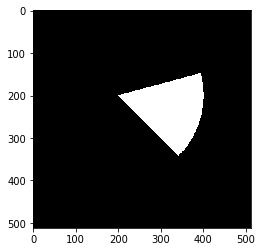

In [73]:
mask = np.zeros((512,512), dtype=np.uint8)
cv2.ellipse(mask, (200,200), (200,200),0, 45+360, 345, (255,255,255), -1)
plt.imshow(mask,'gray')
plt.show()

In [21]:
a = np.array([[1,0,2],[3,4,0],[0,0,5],[0,6,0]])
print(a)
b = np.nonzero(a)
b = np.array(b).T
print(b)
print(b[1])
c = np.array([1,3, 4, 6,2,5])
print("c is: ", c)
b = np.vstack((b,c))
print(b)
df = pd.DataFrame(b.T, columns=["A","B","C"])
df = df.sort_values("C")
df = df.drop("C", axis = 1)
df = df.values
print(df)

[[1 0 2]
 [3 4 0]
 [0 0 5]
 [0 6 0]]
[[0 0]
 [0 2]
 [1 0]
 [1 1]
 [2 2]
 [3 1]]
[0 2]
c is:  [1 3 4 6 2 5]


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [128]:
y = np.arange(35)
print(y)
y = y.reshape(5,7)
print(y)
z = np.array([2,5])
y[:,z]
np.array()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]]


array([[ 2,  5],
       [ 9, 12],
       [16, 19],
       [23, 26],
       [30, 33]])

In [ ]:
df1 = pd.DataFrame([[1,2,3][4,5,6]])
df2 = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


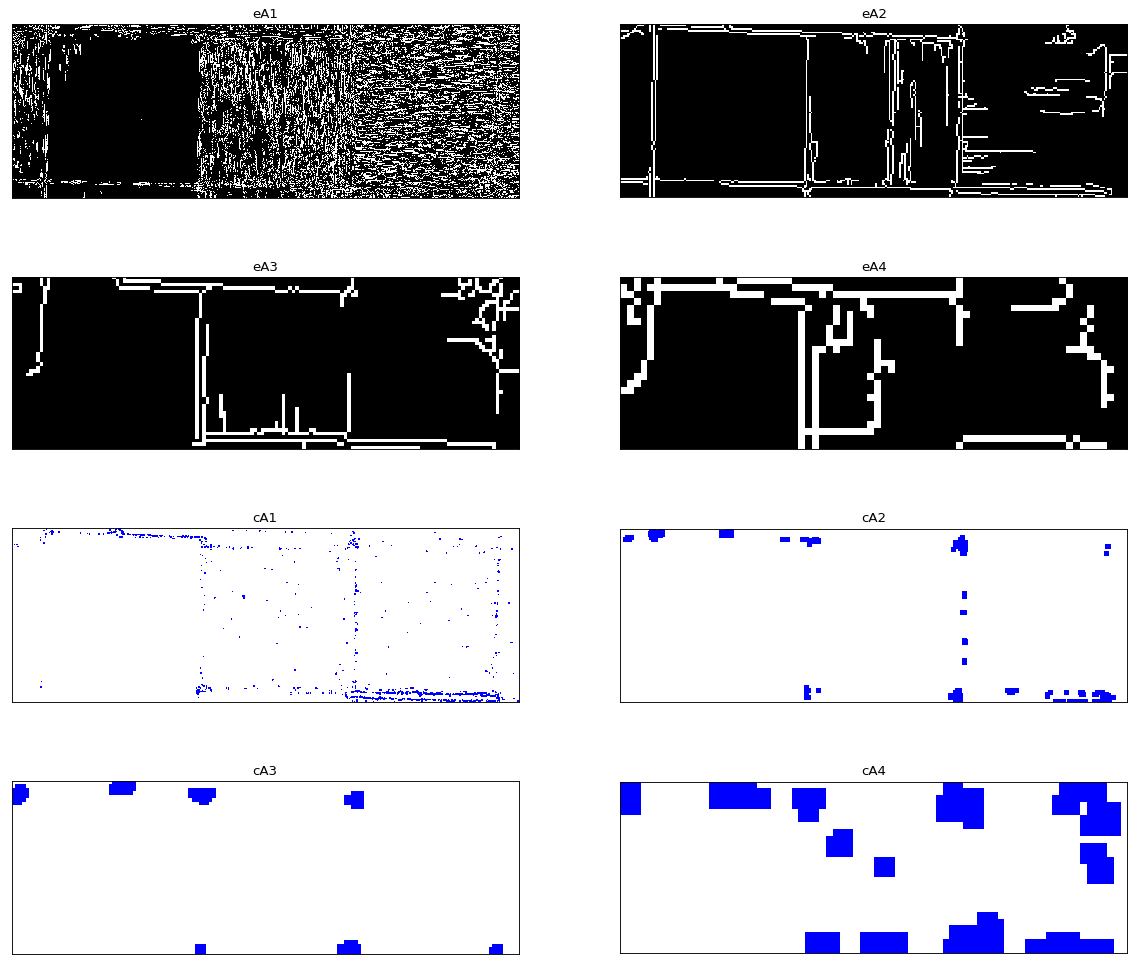

In [18]:
G = img2.copy()
gpA = [G]
cImg = cv2.cvtColor(G,cv2.COLOR_BGR2GRAY)
cImg = np.float32(cImg)
dst = cv2.cornerHarris(cImg,2,1,0.04)
dst = cv2.dilate(dst,None)
cImg = cv2.cvtColor(cImg,cv2.COLOR_GRAY2BGR)
cImg[dst>0.01*dst.max()]=[0,0,255]
cA2 = [cImg]
eA2 = [cv2.Canny(G,50,150)]
for i in range(4):
    G = cv2.pyrDown(G)
    gpA.append(G)
    cImg = cv2.cvtColor(G,cv2.COLOR_BGR2GRAY)
    cImg = np.float32(cImg)
    dst = cv2.cornerHarris(cImg,2,1,0.04)
    dst = cv2.dilate(dst,None)
    cImg = cv2.cvtColor(cImg,cv2.COLOR_GRAY2BGR)
    cImg[dst>0.01*dst.max()]=[0,0,255]
    cA2.append(cImg)
    eA2.append(cv2.Canny(G,50,150))
    
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

titles = ['eA1','eA2','eA3','eA4','cA1','cA2','cA3','cA4']
images = [eA2[0], eA2[2], eA2[3], eA2[4],cA2[0], cA2[2], cA2[3], cA2[4]]

for i in range(8):
    plt.subplot(4,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

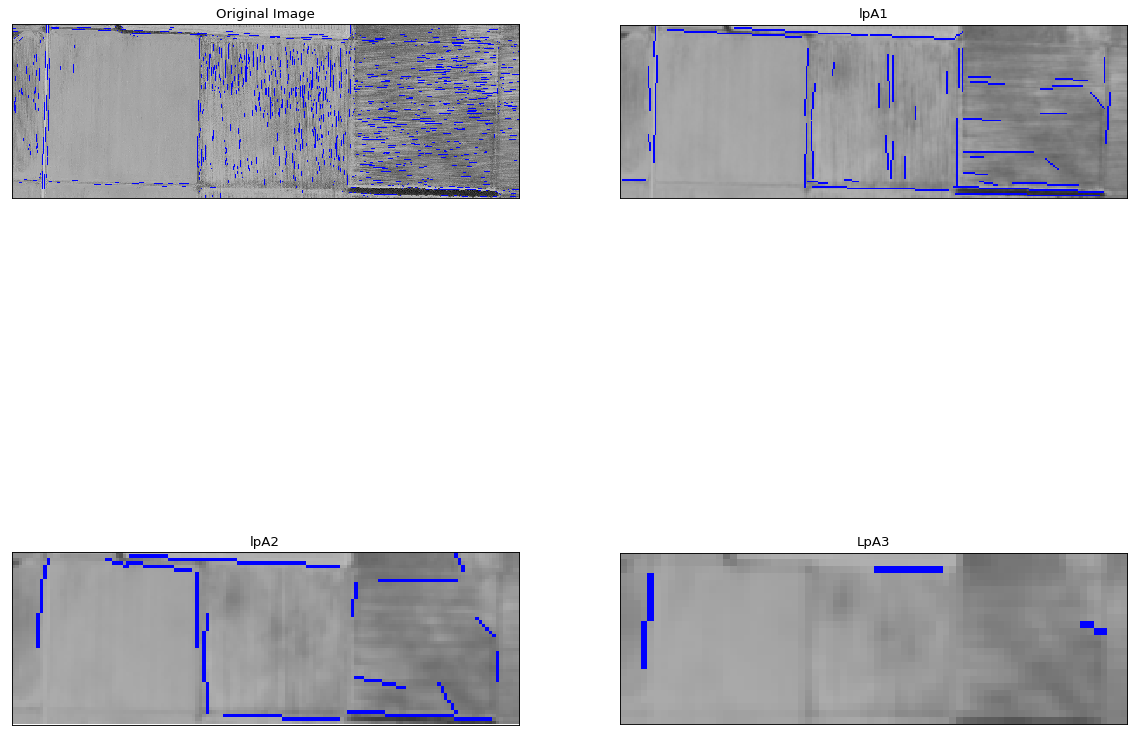

In [4]:
G = img2.copy()
gpA = [G]
eImg = cv2.cvtColor(G,cv2.COLOR_BGR2GRAY)
lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_ADV,0.8,0.6,2,22.5,0,0.01,1024)
lines = lsd.detect(eImg)[0] #Position 0 of the returned tuple are the detected lines
drawn_gray = lsd.drawSegments(eImg,lines)
eA = [drawn_gray]
for i in range(4):
    G = cv2.pyrDown(G)
    gpA.append(G)
    eImg = cv2.cvtColor(G,cv2.COLOR_BGR2GRAY)
    lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_ADV,0.8,0.6,2,22.5,0,0.01,1024)
    lines = lsd.detect(eImg)[0]
    #print(lines)#Position 0 of the returned tuple are the detected lines
    drawn_gray = lsd.drawSegments(eImg,lines)
    eA.append(drawn_gray)
    
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

titles = ['Original Image','lpA1','lpA2','LpA3']
images = [eA[0], eA[2], eA[3], eA[4]]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

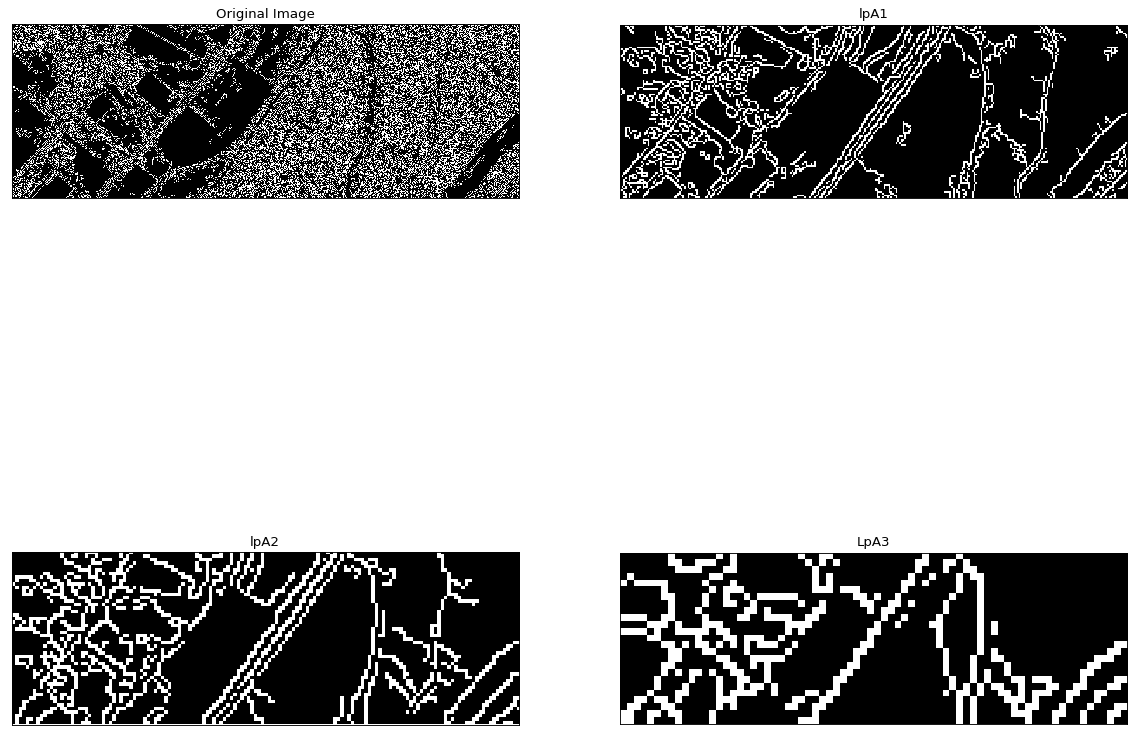

In [172]:
G = img.copy()
gpA = [G]
eA = [cv2.Canny(G,50,150)]
for i in range(4):
    G = cv2.pyrDown(G)
    gpA.append(G)
    eA.append(cv2.Canny(G,50,150))
    

#lpA = [gpA[3]]
#for i in range(3,0,-1):
#    GE = cv2.pyrUp(gpA[i])
#    L = cv2.subtract(gpA[i-1],GE)
#    lpA.append(L)
    
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

titles = ['Original Image','lpA1','lpA2','LpA3']
images = [eA[0], eA[2], eA[3], eA[4]]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


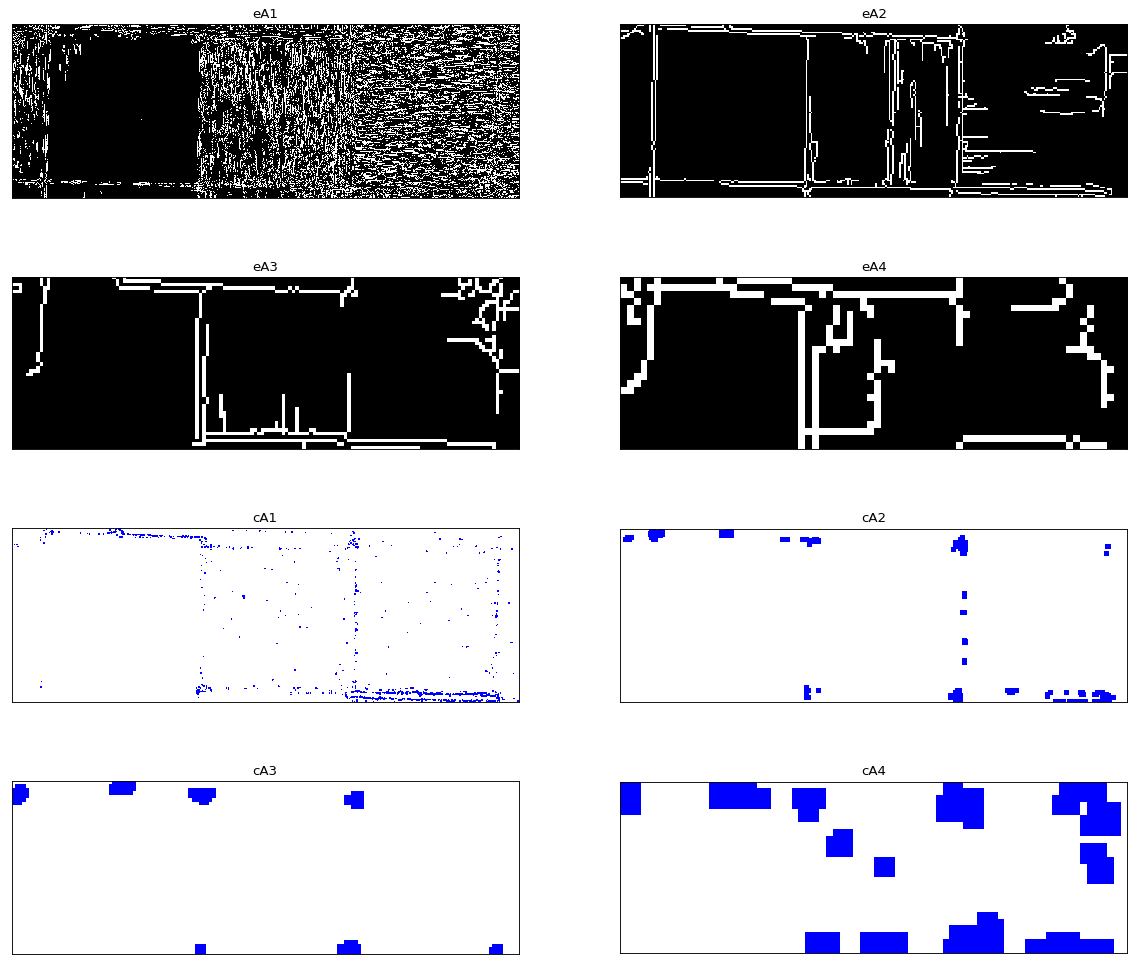

In [7]:
G = img2.copy()
gpA = [G]
cImg = cv2.cvtColor(G,cv2.COLOR_BGR2GRAY)
cImg = np.float32(cImg)
dst = cv2.cornerHarris(cImg,2,1,0.04)
dst = cv2.dilate(dst,None)
cImg = cv2.cvtColor(cImg,cv2.COLOR_GRAY2BGR)
cImg[dst>0.01*dst.max()]=[0,0,255]
cA = [cImg]
eA = [cv2.Canny(G,50,150)]
for i in range(4):
    G = cv2.pyrDown(G)
    gpA.append(G)
    cImg = cv2.cvtColor(G,cv2.COLOR_BGR2GRAY)
    cImg = np.float32(cImg)
    dst = cv2.cornerHarris(cImg,2,1,0.04)
    dst = cv2.dilate(dst,None)
    cImg = cv2.cvtColor(cImg,cv2.COLOR_GRAY2BGR)
    cImg[dst>0.01*dst.max()]=[0,0,255]
    cA.append(cImg)
    eA.append(cv2.Canny(G,50,150))
    
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

titles = ['eA1','eA2','eA3','eA4','cA1','cA2','cA3','cA4']
images = [eA[0], eA[2], eA[3], eA[4],cA[0], cA[2], cA[3], cA[4]]

for i in range(8):
    plt.subplot(4,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

In [31]:
img.shape[0]

400

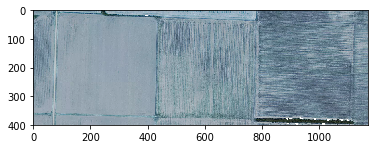

(<matplotlib.image.AxesImage at 0x7faee7854e80>, None)

In [64]:
gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,10,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img2,(x,y),3,255,-1)

plt.imshow(img2),plt.show()

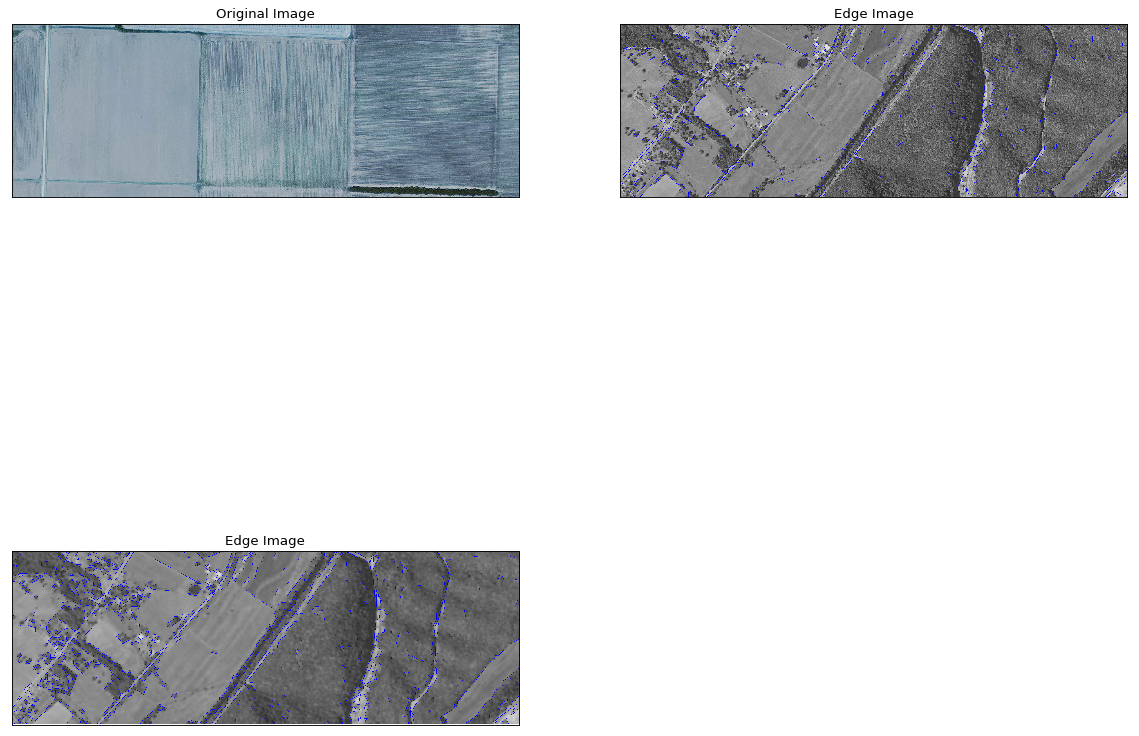

In [195]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#edges = cv2.createLineSegmentDetector.drawSegments(gray,75,125)
blur = cv2.GaussianBlur(gray,(9,9),0)
#edges2 = cv2.createLineSegmentDetector.drawSegments(blur,50,100)

lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_ADV,0.8,0.6,2,22.5,0,0.4,2048)
lines = lsd.detect(gray)[0] #Position 0 of the returned tuple are the detected lines
drawn_gray = lsd.drawSegments(gray,lines)
lsd = cv2.createLineSegmentDetector(0)
lines = lsd.detect(blur)[0] #Position 0 of the returned tuple are the detected lines
drawn_blur = lsd.drawSegments(blur,lines)

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(221),plt.imshow(img2,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(drawn_gray,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(drawn_blur,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

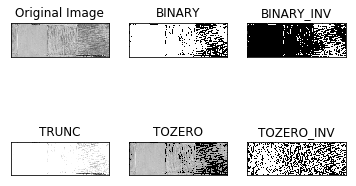

In [117]:
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
ret,thresh1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(gray,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(gray,127,255,cv2.THRESH_TOZERO)
th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [gray, thresh1, thresh2, thresh3, thresh4, th3]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

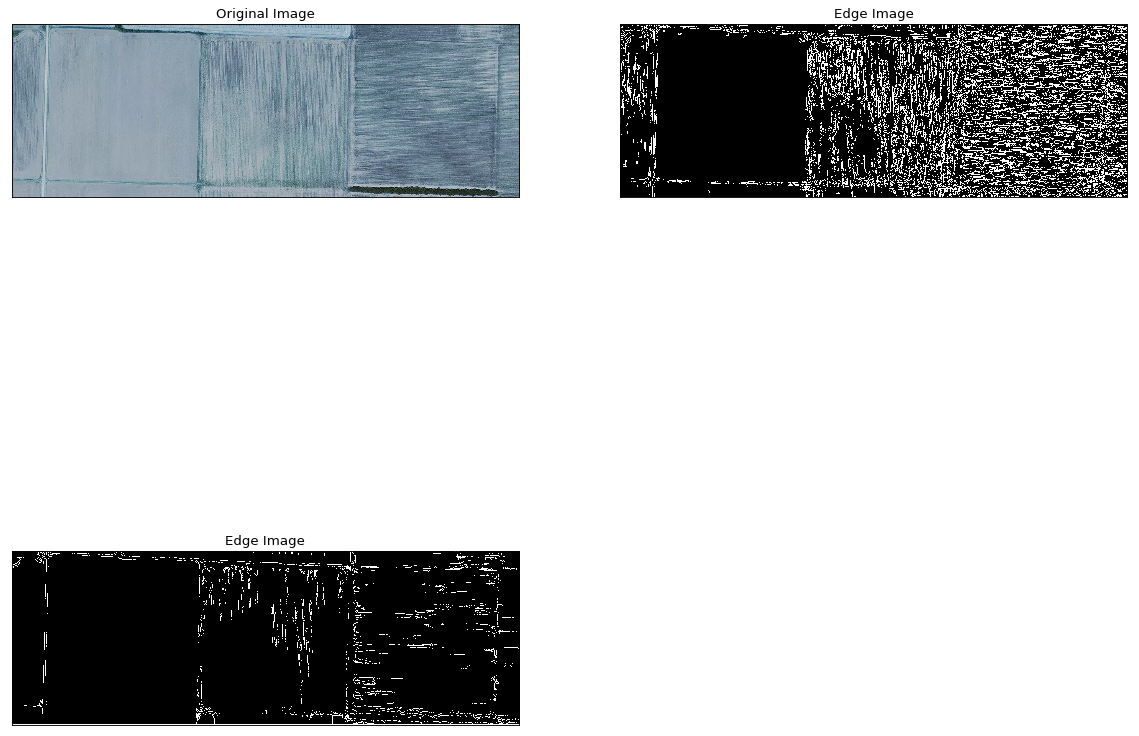

In [146]:
img = cv2.imread('/home/mcfickett/Downloads/field1.png', cv2.IMREAD_UNCHANGED)
lab = cv2.cvtColor(img2, cv2.COLOR_BGR2LAB)
edges = cv2.Canny(lab,50,150)
blur = cv2.GaussianBlur(lab,(3,3),1)
edges2 = cv2.Canny(blur,50,150)

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(221),plt.imshow(img2,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(edges2,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [16]:
print(img.shape)

(400, 1170)


In [9]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
>>> print(flags)

['COLOR_BAYER_BG2BGR', 'COLOR_BAYER_BG2BGRA', 'COLOR_BAYER_BG2BGR_EA', 'COLOR_BAYER_BG2BGR_VNG', 'COLOR_BAYER_BG2GRAY', 'COLOR_BAYER_BG2RGB', 'COLOR_BAYER_BG2RGBA', 'COLOR_BAYER_BG2RGB_EA', 'COLOR_BAYER_BG2RGB_VNG', 'COLOR_BAYER_GB2BGR', 'COLOR_BAYER_GB2BGRA', 'COLOR_BAYER_GB2BGR_EA', 'COLOR_BAYER_GB2BGR_VNG', 'COLOR_BAYER_GB2GRAY', 'COLOR_BAYER_GB2RGB', 'COLOR_BAYER_GB2RGBA', 'COLOR_BAYER_GB2RGB_EA', 'COLOR_BAYER_GB2RGB_VNG', 'COLOR_BAYER_GR2BGR', 'COLOR_BAYER_GR2BGRA', 'COLOR_BAYER_GR2BGR_EA', 'COLOR_BAYER_GR2BGR_VNG', 'COLOR_BAYER_GR2GRAY', 'COLOR_BAYER_GR2RGB', 'COLOR_BAYER_GR2RGBA', 'COLOR_BAYER_GR2RGB_EA', 'COLOR_BAYER_GR2RGB_VNG', 'COLOR_BAYER_RG2BGR', 'COLOR_BAYER_RG2BGRA', 'COLOR_BAYER_RG2BGR_EA', 'COLOR_BAYER_RG2BGR_VNG', 'COLOR_BAYER_RG2GRAY', 'COLOR_BAYER_RG2RGB', 'COLOR_BAYER_RG2RGBA', 'COLOR_BAYER_RG2RGB_EA', 'COLOR_BAYER_RG2RGB_VNG', 'COLOR_BGR2BGR555', 'COLOR_BGR2BGR565', 'COLOR_BGR2BGRA', 'COLOR_BGR2GRAY', 'COLOR_BGR2HLS', 'COLOR_BGR2HLS_FULL', 'COLOR_BGR2HSV', 'COLOR_

In [ ]:
G = img2.copy()
gpA = [G]
eImg = cv2.Canny(G,50,150)
eImg = np.float32(eImg)
dst = cv2.cornerHarris(eImg,2,1,0.04)
dst = cv2.dilate(dst,None)
eImg = cv2.cvtColor(eImg,cv2.COLOR_GRAY2BGR)
eImg[dst>0.01*dst.max()]=[0,0,255]

eA = [eImg]
for i in range(4):
    G = cv2.pyrDown(G)
    gpA.append(G)
    eImg = cv2.Canny(G,50,150)
    eImg = np.float32(eImg)
    dst = cv2.cornerHarris(eImg,2,1,0.04)
    dst = cv2.dilate(dst,None)
    eImg = cv2.cvtColor(eImg,cv2.COLOR_GRAY2BGR)
    eImg[dst>0.01*dst.max()]=[0,0,255]
    eA.append(eImg)
    
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

titles = ['Original Image','lpA1','lpA2','LpA3']
images = [eA[0], eA[2], eA[3], eA[4]]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()